# Função de Mineração de Dados

O objetivo nesta parte do trabalho é identificar regras de propagação de atrasos entre os aeroportos. Isso posto, é utilizado um método de mineração de padrões sequenciais por meio do algoritmo CSPADE.

### 1. Leitura do dataset

In [1]:
load("vra-wu-small.RData")

### 2. Limpeza e transformação de dados

Inicialmente supre-se as mensagens e carrrega-se algumas bibliotecas que serão utilizadas neste trabalho.

In [180]:
message=FALSE # Suprimir mensagens de alerta
library("network")
library("plyr")
library("proto")
library("RSQLite")
library("sqldf")
library("Matrix")
library("grid")
library("arules")
library("arulesSequences")
library("arulesViz")

O arquivo com os dados necessários para executar-se o algoritmo CSPADE deve estar no seguinte formato:
**[SID] [EID] [SIZE]** onde: **[SID]** é um identificador sequencial de uma transação,
**[EID]** é um identificador do evento de uma transação e **[SIZE]** é composto pelo tamanho do conjunto de itens
de uma transação, seguido dos códigos dos itens propriamente dito.<BR><BR>
Neste trabalho, considerando-se o conjunto de dados de voos, tem-se:<BR><BR>
**[SID]** é composto pelo código ICAO do aeroporto mais a data de partida do voo;<BR>
**[EID]** é a hora cheia de partida do voo; e<BR>
**[SIZE]** é composto pelo tamanho do conjunto de números dos voos, seguido pelos números dos voos.<BR><BR>
Observando-se que somente os voos atrasados em mais de 15 minutos e menos de 240 minutos são considerados.

In [6]:
str(vra_wu_2017)

'data.frame':	1268561 obs. of  33 variables:
 $ destiny            : Factor w/ 537 levels "CYYZ","EDDF",..: 19 19 19 19 19 19 19 19 19 19 ...
 $ origin             : Factor w/ 522 levels "CYYZ","EDDF",..: 43 79 79 79 79 76 43 76 43 79 ...
 $ airline            : Factor w/ 119 levels "AAL","ABJ","ACA",..: 10 22 60 60 1 1 1 60 10 22 ...
 $ flight             : Factor w/ 8250 levels "3","4","14","15",..: 341 7217 5165 2066 238 244 6232 2064 341 7217 ...
 $ autho_code         : Factor w/ 11 levels "0","1","2","3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ line_type          : Factor w/ 10 levels "C","E","G","I",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ depart_expect      : POSIXlt, format: "2017-01-01 23:00:00" "2017-01-01 22:25:00" ...
 $ depart             : POSIXlt, format: "2017-01-01 23:00:00" "2017-01-01 22:15:00" ...
 $ arrival_expect     : POSIXlt, format: "2017-01-02 05:05:00" "2017-01-02 08:21:00" ...
 $ arrival            : POSIXlt, format: "2017-01-02 05:05:00" "2017-01-02 08:22:00" ...
 $ status    

In [7]:
summary(vra_wu_2017)

    destiny           origin          airline           flight      
 SBGR   :111020   SBGR   :110583   GLO    :247127   6318   :  1100  
 SBSP   : 89233   SBSP   : 89207   AZU    :245832   2317   :  1096  
 SBBR   : 62783   SBBR   : 62962   TAM    :220514   6319   :  1096  
 SBGL   : 53741   SBGL   : 53182   ONE    : 90068   6312   :  1095  
 SBKP   : 49479   SBKP   : 50535   PTB    : 14668   6313   :  1095  
 (Other):525109   (Other):524896   (Other): 73156   (Other):885883  
 NA's   :377196   NA's   :377196   NA's   :377196   NA's   :377196  
   autho_code       line_type      depart_expect                
 0      :891365   N      :472063   Min.   :2017-01-01 00:00:00  
 1      :     0   R      :244127   1st Qu.:2017-04-01 17:55:00  
 2      :     0   I      : 87673   Median :2017-07-04 17:40:00  
 3      :     0   E      : 43113   Mean   :2017-07-03 15:31:29  
 4      :     0   C      : 22884   3rd Qu.:2017-10-04 06:29:00  
 (Other):     0   (Other): 21505   Max.   :2017-12-31 23:5

Executa-se algumas transformações iniciais para harmonizar o processo.

In [3]:
# Transforma o formato POSIXlt em chr
# para que possa ser trabalhado em conjunto com o sqldf
vra_wu_2017$depart_expect <- as.character(vra_wu_2017$depart_expect)
vra_wu_2017$depart <- as.character(vra_wu_2017$depart)
vra_wu_2017$arrival_expect <- as.character(vra_wu_2017$arrival_expect)
vra_wu_2017$arrival <- as.character(vra_wu_2017$arrival)

Especifica-se uma query para montar o conjunto treinamento.

In [4]:
query<-"select destiny, origin, airline, flight, depart, arrival, departure_delay, arrival_delay,"
query<-paste(query,"depart_temperature, depart_dew_point, depart_humidity, depart_pressure, depart_visibility, depart_events, depart_conditions,", sep=" ")
query<-paste(query,"arrival_temperature, arrival_dew_point, arrival_humidity, arrival_pressure, arrival_visibility, arrival_events, arrival_conditions", sep=" ")
query<-paste(query, "from vra_wu_2017 where status = 'Realizado' or status ='REALIZADO'", sep=" ")

Carrega-se o conjunto treinamento com base na especificação da query acima descrita.

In [5]:
train_set<-sqldf(query)

Considera-se apenas as partidas e as chegadas nos aeroportos domésticos.

In [6]:
sub_set<-train_set[which(train_set$origin=="SBBE"|train_set$origin=="SBBR"|train_set$origin=="SBCF"|
                         train_set$origin=="SBEG"|train_set$origin=="SBFZ"|train_set$origin=="SBGL"|
                         train_set$origin=="SBGR"|train_set$origin=="SBKP"|train_set$origin=="SBPA"|
                         train_set$origin=="SBRF"|train_set$origin=="SBSV"),]

In [7]:
sub_set<-sub_set[which(sub_set$destiny=="SBBE"|sub_set$destiny=="SBBR"|sub_set$destiny=="SBCF"|
                       sub_set$destiny=="SBEG"|sub_set$destiny=="SBFZ"|sub_set$destiny=="SBGL"|
                       sub_set$destiny=="SBGR"|sub_set$destiny=="SBKP"|sub_set$destiny=="SBPA"|
                       sub_set$destiny=="SBRF"|sub_set$destiny=="SBSV"),]

**Outliers**

Remove-se as observações cujos valores dos atrasos nas partidas são negativos.

In [8]:
sub_set<-sub_set[which(sub_set$departure_delay>=0),]

Remove-se as observações cujos valores dos atrasos nas chegadas são negativos.

In [9]:
sub_set<-sub_set[which(sub_set$arrival_delay>=0),]

**Inconsistências**

Remove-se as partidas que são maiores que as chegadas para um mesmo voo.

In [10]:
sub_set<-sub_set[as.Date(sub_set$depart) <= as.Date(sub_set$arrival),]

**Regras internacionais de atraso**

Mantém-se apenas as partidas com atrasos maiores ou iguais a 15 minutos e menores ou iguais a 240 minutos (4 horas).

In [11]:
sub_set<-sub_set[which(sub_set$departure_delay>=15),]

In [12]:
sub_set<-sub_set[which(sub_set$departure_delay<=240),]

Aplica-se a mesma regra para as chegadas.

In [13]:
sub_set<-sub_set[which(sub_set$arrival_delay>=15),]

In [14]:
sub_set<-sub_set[which(sub_set$arrival_delay<=240),]

**Criação de características**

Cria-se as variáveis: **depart_date**, **depart_time**, **arrival_date** e **arrival_time**.

In [15]:
# cria duas listas com todos os valores da coluna depart (index column=5)
# já separados nos formatos YYYY-MM-DD e HH:MM:SS respectivamente
depart_d<-sapply(strsplit(sub_set[,5], " ", fixed = TRUE), "[", 1)
depart_h<-sapply(strsplit(sub_set[,5], " ", fixed = TRUE), "[", 2)

# cria duas listas com todos os valores da coluna arrival (index column=6)
# já separados nos formatos YYYY-MM-DD e HH:MM:SS respectivamente
arrival_d<-sapply(strsplit(sub_set[,6], " ", fixed = TRUE), "[", 1)
arrival_h<-sapply(strsplit(sub_set[,6], " ", fixed = TRUE), "[", 2)

# cria um dataframe intermediário com essas duas novas colunas
intermed_df <- data.frame("depart_date" = depart_d, "depart_time" = depart_h,
                          "arrival_date" = arrival_d, "arrival_time" = arrival_h)

# cria um dataframe com a combinação do dataframe sub_set e intermed_df
flights <- cbind(sub_set,intermed_df)

In [16]:
# Para as novas variáveis criadas
# Transforma o formato Factor em chr
# para que possa ser trabalhado em conjunto com o sqldf
flights$depart_date <- as.character(flights$depart_date)
flights$arrival_date <- as.character(flights$arrival_date)
flights$depart_time <- as.character(flights$depart_time)
flights$arrival_time <- as.character(flights$arrival_time)

Cria-se as variáveis: **depart_tt** e **arrival_tt** que serão utilizadas na formatação do arquivo
que será a entrada do algoritmo CSPADE.

In [17]:
# cria duas listas com todos os valores da coluna depart (index column=24 e 26)
# já separado no formato HH
depart_tt<-substring(flights[,24], 1, 2) 
arrival_tt<-substring(flights[,26], 1, 2)

# cria um dataframe intermediário com essas duas novas colunas
intermed_df <- data.frame("depart_tt" = depart_tt, "arrival_tt" = arrival_tt)

# Adiciona-se ao dataframe atual, a combinação com o dataframe intermed_df
flights <- cbind(flights,intermed_df)

In [18]:
# Para as novas variáveis criadas
# Transforma o formato Factor em chr
# para que possa ser trabalhado em conjunto com o sqldf
flights$depart_tt <- as.character(flights$depart_tt)
flights$arrival_tt <- as.character(flights$arrival_tt)

In [19]:
str(flights)

'data.frame':	24336 obs. of  28 variables:
 $ destiny            : Factor w/ 537 levels "CYYZ","EDDF",..: 48 48 48 48 48 48 48 48 48 48 ...
 $ origin             : Factor w/ 522 levels "CYYZ","EDDF",..: 52 79 119 76 79 76 79 52 79 76 ...
 $ airline            : Factor w/ 119 levels "AAL","ABJ","ACA",..: 60 60 13 28 28 28 28 60 115 28 ...
 $ flight             : Factor w/ 8250 levels "3","4","14","15",..: 5834 3643 6049 6422 548 6422 548 1038 6290 6422 ...
 $ depart             : chr  "2017-01-01 15:50:00" "2017-01-02 11:12:00" "2017-01-02 14:29:00" "2017-01-02 22:35:00" ...
 $ arrival            : chr  "2017-01-01 18:10:00" "2017-01-02 14:56:00" "2017-01-02 17:01:00" "2017-01-03 02:08:00" ...
 $ departure_delay    : num  120 17 63 20 42 19 24 105 103 60 ...
 $ arrival_delay      : num  119 34 58 18 37 16 22 83 95 58 ...
 $ depart_temperature : num  29 25 30 30 20 26 26 24 31 23 ...
 $ depart_dew_point   : num  11 20 23 22 19 20 21 19 21 21 ...
 $ depart_humidity    : num  33 74 66 62 9

**Agregação Temporal**

Transforma-se a série de voos em uma série temporal com observações hora a hora com os voos agrupados pela concatenação
do código ICAO do aeroporto mais a data de realização da partida ou da chegada, ordenados por esse agrupamento e pela
agregação temporal considerando-se a hora cheia.<BR>
Calcula-se o tamanho de cada agrupamento [SIZE] por meio do somatório dos voos em cada agrupamento.

Analisando-se a rede de atrasos nas partidas e nas chegadas.

In [48]:
query<-"select flight, origin||depart_date as sequenceID, depart_tt as eventID, destiny, arrival_date, arrival_tt,
departure_delay, arrival_delay, depart_conditions, arrival_conditions"
query<-paste(query, "from flights where origin='SBBE' and depart_date='2017-01-01'", sep=" ")

In [49]:
partidas<-sqldf(query)

In [50]:
partidas

flight,sequenceID,eventID,destiny,arrival_date,arrival_tt,departure_delay,arrival_delay,depart_conditions,arrival_conditions
3233,SBBE2017-01-01,18,SBBR,2017-01-01,21,123,126,Thunderstorm,Partly Cloudy
1679,SBBE2017-01-01,17,SBGR,2017-01-01,21,38,68,Thunderstorm,Clear


In [51]:
query<-"select flight, destiny||arrival_date as sequenceID, arrival_tt as eventID, origin, depart_date, depart_tt,
departure_delay, arrival_delay, depart_conditions, arrival_conditions"
query<-paste(query, "from flights where destiny='SBBE' and arrival_date='2017-01-01'", sep=" ")

In [52]:
chegadas<-sqldf(query)

In [53]:
chegadas

flight,sequenceID,eventID,origin,depart_date,depart_tt,departure_delay,arrival_delay,depart_conditions,arrival_conditions
3796,SBBE2017-01-01,18,SBBR,2017-01-01,15,120,119,Mostly Cloudy,Thunderstorm


In [61]:
query<-"select * from partidas union select * from chegadas"

In [62]:
result<-sqldf(query)

In [56]:
result

flight,sequenceID,eventID,destiny,arrival_date,arrival_tt,departure_delay,arrival_delay,depart_conditions,arrival_conditions
1679,SBBE2017-01-01,17,SBGR,2017-01-01,21,38,68,Thunderstorm,Clear
3233,SBBE2017-01-01,18,SBBR,2017-01-01,21,123,126,Thunderstorm,Partly Cloudy
3796,SBBE2017-01-01,18,SBBR,2017-01-01,15,120,119,Mostly Cloudy,Thunderstorm


Acima, tem-se um conjunto de dados no formato **single** de todas as partidas e chegadas com atraso.<BR><BR>
Quando um conjunto de dados está neste formato, cada observação representa um único item e cada item contém um identificador de transação.

Cria-se um novo conjunto de dados, apenas com as colunas necessárias para a criação de arquivo TXT no formato **basket**.

In [63]:
query<-"select flight as items, sequenceID, eventid, 1 as SIZE from result"

In [64]:
agg<-sqldf(query)

In [65]:
agg

items,sequenceID,eventID,SIZE
1679,SBBE2017-01-01,17,1
3233,SBBE2017-01-01,18,1
3796,SBBE2017-01-01,18,1


Quando o arquivo está no formato **basket** cada observação representa uma transação onde os itens estão em uma mesma coluna.

Cria-se então, um conjunto de dados no formato **basket**.

In [155]:
basket <- ddply(agg,c("sequenceID","eventID","SIZE"), 
                       function(df1)paste(df1$items, 
                       collapse = " "))

In [156]:
basket

sequenceID,eventID,SIZE,V1
SBBE2017-01-01,17,1,1679
SBBE2017-01-01,18,1,3233 3796


In [157]:
# Renomeando as colunas com os nomes corretos na sequência
colnames(basket) <- c("sequenceID","eventID","SIZE","items")

In [158]:
basket

sequenceID,eventID,SIZE,items
SBBE2017-01-01,17,1,1679
SBBE2017-01-01,18,1,3233 3796


In [159]:
# Calculando o SIZE com base nos items
basket$SIZE<-sapply(strsplit(basket$items," "),length)

In [160]:
basket

sequenceID,eventID,SIZE,items
SBBE2017-01-01,17,1,1679
SBBE2017-01-01,18,2,3233 3796


In [161]:
# Removendo o hífen da coluna sequenceID
basket$sequenceID<-gsub("-", "", basket$sequenceID)

In [162]:
basket

sequenceID,eventID,SIZE,items
SBBE20170101,17,1,1679
SBBE20170101,18,2,3233 3796


**Gravando o arquivo TXT no formato BASKET**

In [168]:
write.table(basket, "basket_flights.txt", quote = FALSE, eol = "\n", row.names = FALSE,
            col.names = FALSE, fileEncoding = "UTF-8")

**Lendo o arquivo gravado**

In [169]:
x <- read_baskets(con = "basket_flights.txt", info = c("sequenceID","eventID","SIZE"))

In [170]:
as(x, "data.frame")

items,sequenceID,eventID,SIZE
{1679},SBBE20170101,17,1
"{3233,3796}",SBBE20170101,18,2


**Executando o algoritmo CSPADE**

Sequências Frequentes com um suporte mínimo de 50% (ou seja, a sub-sequência ocorre em no mínimo 2 sequências de entrada).

In [171]:
s <- cspade(x, parameter = list(support = 0.5), control = list(verbose = TRUE))


parameter specification:
support : 0.5
maxsize :  10
maxlen  :  10

algorithmic control:
bfstype  : FALSE
verbose  :  TRUE
summary  : FALSE
tidLists : FALSE

preprocessing ... 1 partition(s), 0 MB [1.2s]
mining transactions ... 0 MB [0.53s]
reading sequences ... [0.42s]

total elapsed time: 2.14s


**Visualizando as sequências**

In [172]:
df <- as(s, "data.frame")

In [173]:
df

sequence,support
<{1679}>,1
<{3233}>,1
<{3796}>,1
"<{1679},{3796}>",1
"<{3233,3796}>",1
"<{1679},{3233,3796}>",1
"<{1679},{3233}>",1


Tem-se na lista acima, os padrões sequenciais dos voos atrasados.

**Induzindo a geração das regras de atraso neste aeroporto específico (SBBE)**

In [174]:
## usando uma confiança elevada
sequenceRules <- ruleInduction(s, confidence = .95, control = list(verbose = TRUE))
summary(sequenceRules)

set of 3 sequencerules with

rule size distribution (lhs + rhs)
sizes
2 
3 

rule length distribution (lhs + rhs)
lengths
2 3 
2 1 

summary of quality measures:
    support    confidence      lift  
 Min.   :1   Min.   :1    Min.   :1  
 1st Qu.:1   1st Qu.:1    1st Qu.:1  
 Median :1   Median :1    Median :1  
 Mean   :1   Mean   :1    Mean   :1  
 3rd Qu.:1   3rd Qu.:1    3rd Qu.:1  
 Max.   :1   Max.   :1    Max.   :1  

mining info:
 data ntransactions nsequences support confidence
    x             2          1     0.5       0.95

In [175]:
inspect(sequenceRules)

   lhs         rhs      support confidence lift 
 1 <{1679}> => <{3796}>       1          1    1 
 2 <{1679}> => <{3233,        1          1    1 
                 3796}>    
 3 <{1679}> => <{3233}>       1          1    1 
 


Considerando-se um suporte de 100% e confiança de 95%, tem-se:<BR><BR>
1. O atraso do voo 1679 implica no atraso dos voo 3796;<BR>
2. O atraso dos voos 1679, implica no atraso conjunto dos voos 3233 e 3796; e <BR>
3. O atraso do voo 1679 implica no atraso do voo 3233;<BR><BR>
Logo, tem-se uma propagação de atraso entre esses voos.

**Exibindo um GRAFO de propagação de atraso no aeroporto SBBE**

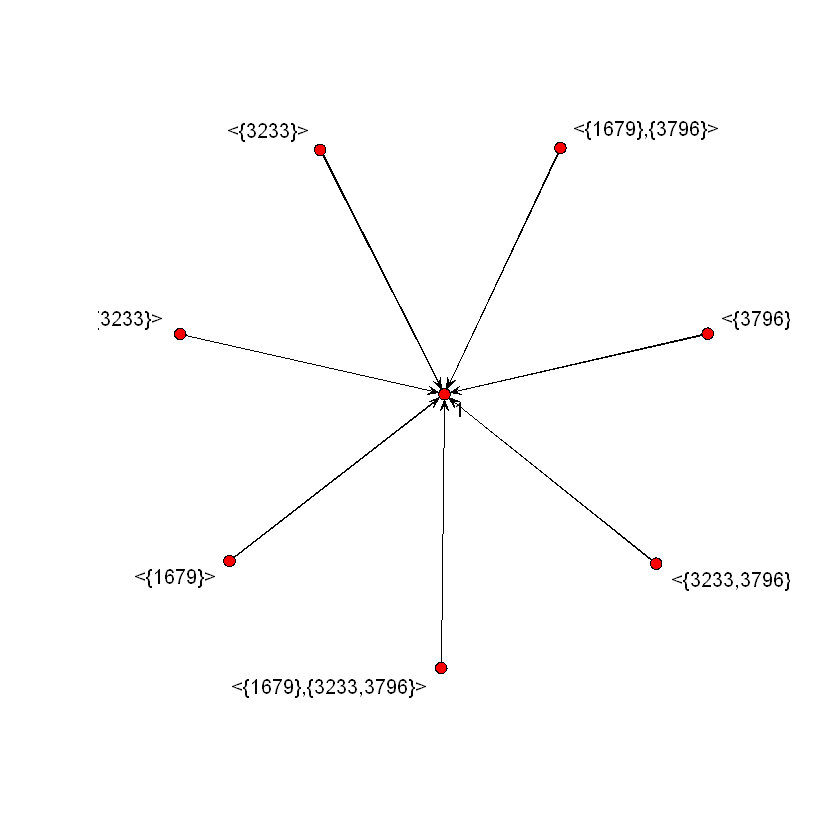

In [179]:
Flight_Graph<-network(df)
plot(Flight_Graph, usearrows=TRUE, displaylabels=TRUE)